<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Carga de Librerias

#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1d4vCP8usSYBLYxBfpLYl-lMAY1etbOB5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d4vCP8usSYBLYxBfpLYl-lMAY1etbOB5" -O model_vae.zip && rm -rf /tmp/cookies.txt
#!unzip /content/model_vae.zip

from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
AUDIO_LOAD = []
etiquetas = []
track_num = []

# En la siguente celda puedes subir tus archivos.
1. Escoge el nombre del grupo de audios.
2. Evalúa la celda.
3. Repite hasta tener todos los conjuntos que necesites

In [48]:
#@title Carga de archivos
## 

from google.colab import files
#@ tectInserta
text = 'tamarindo' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

Saving am_9.wav to am_9.wav
Saving am_10.wav to am_10.wav
Saving am_11.wav to am_11.wav
am_9.wav
am_10.wav
am_11.wav


En la siguiente celda podrás visualizar una tabla con múltiples características que los describen

In [49]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,gm,gm0,am_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16.60379085315592, 19.676663396561846, 17.806...",64.213772
1,gm,gm1,am_1.wav,"[-3.850728e-05, -6.303611e-05, -5.3167285e-05,...","[24.66579652924454, 13.096341579568945, 25.799...",64.866835
2,am,am0,fm_38.wav,"[0.00053887255, -0.0005643648, -0.0019602552, ...","[-11.124943542709673, -11.124943542709673, -11...",1257.619505
3,am,am1,fm_39.wav,"[-0.0036478543, -0.0015628064, 0.004836364, 0....","[-14.37303498311475, -14.37303498311475, -14.3...",1015.844088
4,ring,ring0,fm_90.wav,"[-0.014951301, -0.022364369, -0.017100992, -0....","[-15.913407820794305, -15.913407820794305, -15...",1254.912312
5,ring,ring1,fm_91.wav,"[0.0054331687, 0.0090007195, 0.0077123437, 0.0...","[-7.629483513488623, -7.629483513488623, -7.62...",211.589934
6,tamarindo,tamarindo0,am_9.wav,"[-0.15124077, -0.23614876, -0.1822076, -0.1816...","[17.37329946163253, 21.485754270981985, 17.393...",121.835825
7,tamarindo,tamarindo1,am_10.wav,"[-0.013462398, -0.022104243, -0.018687122, -0....","[1.5187834306443633, -3.0665358092303876, -3.8...",52.598838
8,tamarindo,tamarindo2,am_11.wav,"[-0.18287453, -0.28812802, -0.22628835, -0.228...","[20.78121396284537, 20.639145457398445, 20.730...",115.758752


In [ ]:
#@title Carga de archivos
from google.colab import files
synth_names = ['am','fm','waveshapping', 'res', 'grain']
AUDIO_LOAD = []
sr16k = 16000
secs = 1

uploaded = files.upload()

for name in synth_names:
  for idx, track in enumerate(uploaded.keys()):
    if track.startswith(name) and track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      AUDIO_LOAD.append({'synth': name , 'data': data, 'fft': fft, 'f0': f0})

##dataframe ordenado que contiene el tipo de sintesis y datos
DATA = pd.DataFrame(AUDIO_LOAD)
DATA.sort_values(['synth'], ignore_index= True)

print('User uploaded file "{name}" with length {length} bytes'.format(
      name= track, length=len(uploaded[track])))


Saving am_95.wav to am_95 (1).wav
Saving am_96.wav to am_96 (1).wav
Saving am_97.wav to am_97 (1).wav
Saving am_98.wav to am_98 (1).wav
Saving am_99.wav to am_99 (1).wav
Saving fm_0.wav to fm_0 (1).wav
Saving fm_1.wav to fm_1 (1).wav
Saving fm_2.wav to fm_2 (1).wav
Saving fm_3.wav to fm_3 (1).wav
User uploaded file "fm_3.wav" with length 144044 bytes


In [ ]:
DATA

,synth,data,fft,f0
0,am,"[-0.00818744, -0.013489313, -0.01148957, -0.01...","[29.998858815334888, 33.5016230218874, 27.9530...",42.997139
1,am,"[0.01085618, 0.016928338, 0.013098712, 0.01318...","[-10.570642046269827, -0.5993486391352881, -3....",56.605462
2,am,"[-0.008428443, -0.013758326, -0.011523944, -0....","[22.0410095503933, 13.597688002251992, 27.0044...",46.341196
3,am,"[-0.037486233, -0.06086411, -0.05052326, -0.05...","[14.641396607307396, 20.052729812689456, 26.72...",45.382902
4,am,"[-0.00027053436, -9.2142545e-05, 0.00050722994...","[52.43897174905805, 51.64440793278107, 50.5763...",63.624312
5,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25889491303950407, 0.2680221702150522, 0.27...",2046.747629
6,fm,"[0.004135562, 0.014386324, 0.013820173, 0.0033...","[-20.15323281401863, -20.15323281401863, -20.1...",2285.714286
7,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-18.962263106719917, -18.02773039457762, -18....",193.033735
8,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-15.324222208801288, -15.324222208801288, -15...",1707.857958


In [50]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt

out = widgets.interactive_output(datafilter, update_sliders)

display(ui,out)

Output()

In [ ]:
#@title Filtrado
### se debe arreglar que se puede subir de todas las tecnicas de sintesis y al mismo
### si se omite alguna que no genere error

count = np.array(DATA['synth'].value_counts())
am_data = widgets.IntSlider(value = count[0], max= count[0], step = 1, description='am data')
fm_data = widgets.IntSlider(value = count[1], max= count[1], description= 'fm data')
#c = widgets.IntSlider(value = count[0], max= count[0], description='b')
ui = widgets.VBox([am_data, fm_data])

def f(a, b):
  df = DATA.iloc[0: am_data.value]
  df_2 = DATA.iloc[count[0]: fm_data.value + count[0]]
  #df_3 = DATA.iloc[b: c]
  DATA_filt = pd.concat([df, df_2])
  #print(type(DATA_filt))
  print(DATA_filt['synth'])
  return DATA_filt

out = widgets.interactive_output(f, {'a': am_data, 'b': fm_data})

display(ui, out)

In [ ]:
#@title Filtrado
### se debe arreglar que se puede subir de todas las tecnicas de sintesis y al mismo
### si se omite alguna que no genere error

count = np.array(DATA['synth'].value_counts())
am_data = widgets.IntSlider(value = count[0], max= count[0], step = 1, description='am data')
fm_data = widgets.IntSlider(value = count[1], max= count[1], description= 'fm data')
#c = widgets.IntSlider(value = count[0], max= count[0], description='b')
ui = widgets.VBox([am_data, fm_data])

def f(a, b):
  df = DATA.iloc[0: am_data.value]
  df_2 = DATA.iloc[count[0]: fm_data.value + count[0]]
  #df_3 = DATA.iloc[b: c]
  DATA_filt = pd.concat([df, df_2])
  #print(type(DATA_filt))
  print(DATA_filt['synth'])
  return DATA_filt

out = widgets.interactive_output(f, {'a': am_data, 'b': fm_data})

display(ui, out)

Output()

In [ ]:
#@title DATASET

df = DATA.iloc[0: am_data.value]
df_2 = DATA.iloc[count[0]: fm_data.value + count[0]]
#df_3 = DATA.iloc[b: c]
DATA_filt = pd.concat([df, df_2])
DATA_filt

,synth,data,fft,f0
0,am,"[-0.00818744, -0.013489313, -0.01148957, -0.01...","[29.998858815334888, 33.5016230218874, 27.9530...",42.997139
1,am,"[0.01085618, 0.016928338, 0.013098712, 0.01318...","[-10.570642046269827, -0.5993486391352881, -3....",56.605462
2,am,"[-0.008428443, -0.013758326, -0.011523944, -0....","[22.0410095503933, 13.597688002251992, 27.0044...",46.341196
3,am,"[-0.037486233, -0.06086411, -0.05052326, -0.05...","[14.641396607307396, 20.052729812689456, 26.72...",45.382902
4,am,"[-0.00027053436, -9.2142545e-05, 0.00050722994...","[52.43897174905805, 51.64440793278107, 50.5763...",63.624312
5,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25889491303950407, 0.2680221702150522, 0.27...",2046.747629
6,fm,"[0.004135562, 0.014386324, 0.013820173, 0.0033...","[-20.15323281401863, -20.15323281401863, -20.1...",2285.714286
7,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-18.962263106719917, -18.02773039457762, -18....",193.033735
8,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-15.324222208801288, -15.324222208801288, -15...",1707.857958


In [ ]:

data_fft = np.vstack(DATA_filt['fft'])
print(data_fft.shape)


mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft

print(Xmu_FFT.shape)

DATA_filt = DATA_filt.reset_index(drop = True)
indices = list(DATA_filt[DATA_filt['synth'] == 'am'].index)
indices2 = list(DATA_filt[DATA_filt['synth'] == 'fm'].index)
DATA_filt

(9, 16000)
(9, 16000)


,synth,data,fft,f0
0,am,"[-0.00818744, -0.013489313, -0.01148957, -0.01...","[29.998858815334888, 33.5016230218874, 27.9530...",42.997139
1,am,"[0.01085618, 0.016928338, 0.013098712, 0.01318...","[-10.570642046269827, -0.5993486391352881, -3....",56.605462
2,am,"[-0.008428443, -0.013758326, -0.011523944, -0....","[22.0410095503933, 13.597688002251992, 27.0044...",46.341196
3,am,"[-0.037486233, -0.06086411, -0.05052326, -0.05...","[14.641396607307396, 20.052729812689456, 26.72...",45.382902
4,am,"[-0.00027053436, -9.2142545e-05, 0.00050722994...","[52.43897174905805, 51.64440793278107, 50.5763...",63.624312
5,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25889491303950407, 0.2680221702150522, 0.27...",2046.747629
6,fm,"[0.004135562, 0.014386324, 0.013820173, 0.0033...","[-20.15323281401863, -20.15323281401863, -20.1...",2285.714286
7,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-18.962263106719917, -18.02773039457762, -18....",193.033735
8,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-15.324222208801288, -15.324222208801288, -15...",1707.857958


In [ ]:
DATA_filt['fft'][0].shape

(16000,)

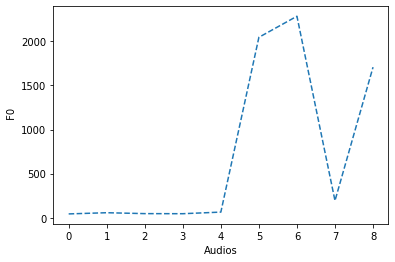

In [ ]:
#@title Visualización de datos
audio_viz = 'F0' #@param ['PCA','F0', 'histogram']
fig, ax = plt.subplots()
if audio_viz == 'histogram':
  ax = DATA_filt['synth'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  plt.show()
if audio_viz == 'PCA':
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  ax.scatter(X_PCA[0: indices2[0], 0], X_PCA[0: indices2[0], 1], c='gray', label = synth_names[0])
  ax.scatter(X_PCA[indices2[0]:, 0], X_PCA[indices2[0]:, 1], c='red', label = synth_names[1])
  fig.add_axes(ax)
  plt.legend()
  plt.title('Latent Space PCA')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()


In [ ]:
#@title Entrenamiento del modelo
'''
##############preparacion de datos
data = np.vstack(DATA_filt['data'])
#data.shape

mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]

Xw = (data- mu_wave)/max_wave
## para evitar la division entre ceros
#Xw = np.divide(Xw, max_wave, out=np.zeros(Xw.shape, dtype=float), where=max_wave!=0)
#print(Xw.shape)

Xw = Xw[...,np.newaxis][...,np.newaxis]
#print(Xw.shape)
'''
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.000001, clipvalue=0.5)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))


latent_dim = 128
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64,(66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
#vae_encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
#vae_decoder.summary()


# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

from keras.utils.vis_utils import plot_model

#plot_model(vae_encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#plot_model(vae_decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= 5, epochs= 9)


In [ ]:
vae.save('model_vae')


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= 5, epochs= 90)


Epoch 1/90
2/2 [==============================] - 1s 63ms/step - loss: 0.1023
Epoch 2/90
2/2 [==============================] - 0s 46ms/step - loss: 0.1023
Epoch 3/90
2/2 [==============================] - 0s 45ms/step - loss: 0.1023
Epoch 4/90
2/2 [==============================] - 0s 34ms/step - loss: 0.1023
Epoch 5/90
2/2 [==============================] - 0s 35ms/step - loss: 0.1023
Epoch 6/90
2/2 [==============================] - 0s 36ms/step - loss: 0.1023
Epoch 7/90
2/2 [==============================] - 0s 34ms/step - loss: 0.1023
Epoch 8/90
2/2 [==============================] - 0s 35ms/step - loss: 0.1023
Epoch 9/90
2/2 [==============================] - 0s 35ms/step - loss: 0.1023
Epoch 10/90
2/2 [==============================] - 0s 33ms/step - loss: 0.1023
Epoch 11/90
2/2 [==============================] - 0s 33ms/step - loss: 0.1023
Epoch 12/90
2/2 [==============================] - 0s 36ms/step - loss: 0.1023
Epoch 13/90
2/2 [==============================] - 0s 33ms/st

In [ ]:
from google.colab import files
!zip -r /content/model_vae.zip /content/model_vae


  adding: content/model_vae/ (stored 0%)
  adding: content/model_vae/keras_metadata.pb (deflated 95%)
  adding: content/model_vae/assets/ (stored 0%)
  adding: content/model_vae/saved_model.pb (deflated 90%)
  adding: content/model_vae/variables/ (stored 0%)
  adding: content/model_vae/variables/variables.index (deflated 61%)
  adding: content/model_vae/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
files.download('/content/model_vae.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

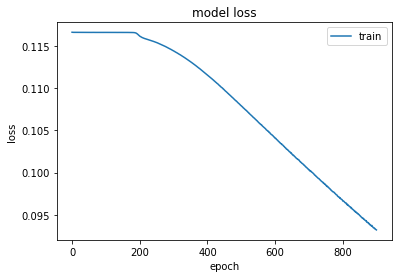

In [ ]:
plt.plot(tr_logs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
latent = vae_encoder.predict(Xw)
latent[0].shape

7/7 [==============================] - 0s 34ms/step


(199, 128)

variance: 
[0.71709704 0.18853576]


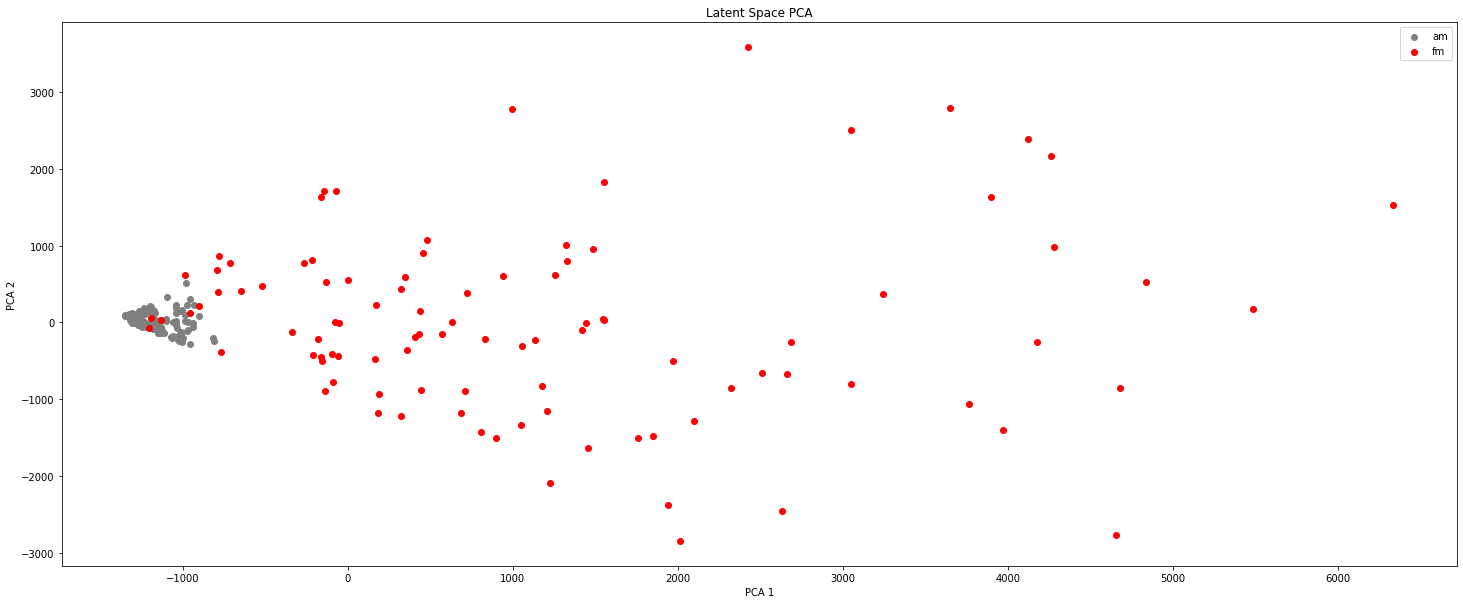

In [ ]:
#@title Visualización del espacio latente


fig, ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)
X_PCA = pca.fit_transform(latent[0])
print('variance: ')
print(pca.explained_variance_ratio_)
ax.scatter(X_PCA[0: indices2[0], 0], X_PCA[0: indices2[0], 1], c='gray', label = synth_names[0])
ax.scatter(X_PCA[indices2[0]:, 0], X_PCA[indices2[0]:, 1], c='red', label = synth_names[1])
fig.add_axes(ax)
plt.legend()
plt.title('Latent Space PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.zlabel('PCA 3')

plt.show()


7/7 [==============================] - 1s 57ms/step
[0, 1, 2]


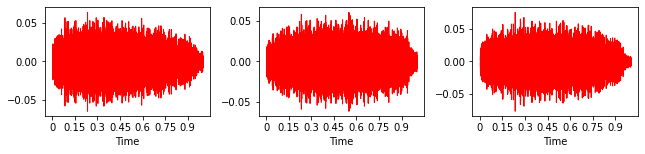

In [ ]:
y_hat = vae.predict(Xw)
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(3)]
print(sonidos)
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1)
    librosa.display.waveshow(y_hat[x].flatten(),16000, color='r')
plt.tight_layout()
plt.show()

In [ ]:
#@title Generación de Audios
referencia_1 = '-' #@param ['Interpolación lineal','Vecinos euclidaneos','-']
referencia_2 = '-' #@param ['Interpolación lineal','Vecinos euclidaneos','-']

tecnicas = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

In [ ]:
##Visualización y escucha de los audios
##descarga de audios

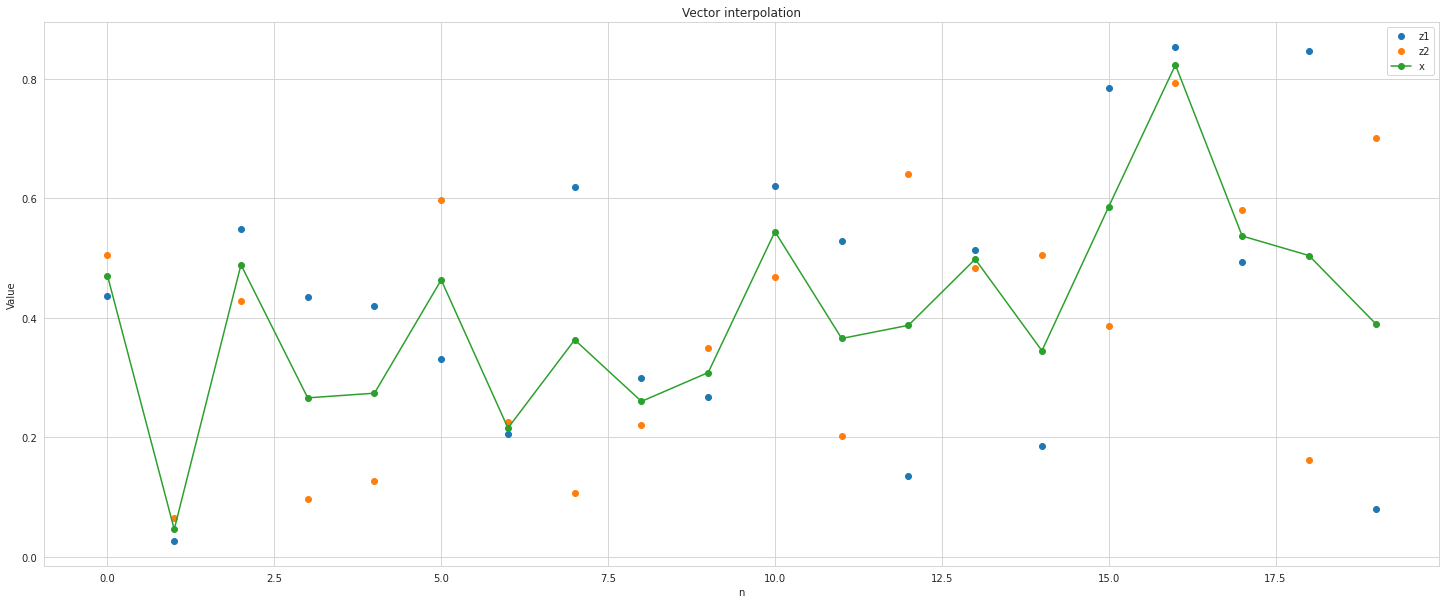

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig , ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)
np.random.seed(2)
x = [np.random.random(20),np.random.random(20)]

x_mu= np.mean(x, axis = 1)[...,np.newaxis]
s_fft = np.std(x, axis = 1)[...,np.newaxis]
Xmu_ = x - x_mu/s_fft

z = x[0] + x[1] 
z = 0.5 * z
d = {'x': x[0], 'y': x[1], 'z': z}
df = pd.DataFrame(d)
#print(df)
ax.plot(df.index,x[0], marker = 'o',linestyle = "None", label = 'z1')
ax.plot(df.index,x[1], marker = 'o', linestyle = "None", label = 'z2')
ax.plot(df.index,z, marker = 'o', label = 'x')
ax.set_title('Vector interpolation')
ax.set_xlabel('n')
ax.set_ylabel('Value')
ax.legend()
plt.show()




In [ ]:
#fig , ax = plt.subplots()
#fig.set_figwidth(25)
#fig.set_figheight(10)
#np.random.seed(2)
x = [np.random.random(20),np.random.random(20)]

x_mu= np.mean(x, axis = 1)[...,np.newaxis]
s_fft = np.std(x, axis = 1)[...,np.newaxis]
Xmu_ = x - x_mu/s_fft

z = x[0] + x[1] 
w = np.array([1* i for i in range(1,11)])
print(w)


#ax.scatter(range(10),x)
'''
z = 0.5 * z
d = {'x': x[0], 'y': x[1], 'z': z}
df = pd.DataFrame(d)
#print(df)
ax.plot(df.index,x[0], marker = 'o',linestyle = "None", label = 'z1')
ax.plot(df.index,x[1], marker = 'o', linestyle = "None", label = 'z2')
ax.plot(df.index,z, marker = 'o', label = 'x')
ax.set_title('Vector interpolation')
ax.set_xlabel('n')
ax.set_ylabel('Value')
ax.legend()
plt.show()
'''

[ 1  2  3  4  5  6  7  8  9 10]


'\nz = 0.5 * z\nd = {\'x\': x[0], \'y\': x[1], \'z\': z}\ndf = pd.DataFrame(d)\n#print(df)\nax.plot(df.index,x[0], marker = \'o\',linestyle = "None", label = \'z1\')\nax.plot(df.index,x[1], marker = \'o\', linestyle = "None", label = \'z2\')\nax.plot(df.index,z, marker = \'o\', label = \'x\')\nax.set_title(\'Vector interpolation\')\nax.set_xlabel(\'n\')\nax.set_ylabel(\'Value\')\nax.legend()\nplt.show()\n'

In [ ]:
#@title Entrenamiento { run: "auto" }
from google.colab import files

referencia_1 = 'Nuevo modelo' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 300 #@param {type: "integer"}
batches = 10 #@param {type: "integer"}
Lr = 0.4241 #@param {type: "slider", min:0.0001, max: 1, step:0.001}
if referencia_1 == 'mi modelo': 
  print('aaaa')
  uploaded_model = files.upload()
  print(uploaded_model)
  saved_model = list(uploaded_model.keys())[0]
 
else:
  print('qqqqq')

#files.download('example_file.csv')



aaaa


KeyboardInterrupt: ignored

'am_4.wav'